# Gaussian Process Latent Variable Model

In [1]:
import numpy as np
import GPy
import cv2

w,h = 120,90

sample = np.load('data\samplevideo.npy')
print(sample[0,:])

[ 116.  121.  130. ...,  109.   67.   65.]


In [2]:
def show_frame(frame):
    
    mp.imshow(frame.reshape((h,w)),cmap='Greys_r')

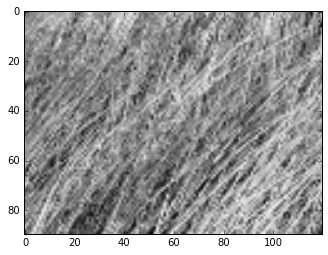

In [3]:
# Plot the first frame
import matplotlib.pyplot as mp
% matplotlib inline
show_frame(sample[0,:])

In [4]:
N = sample.shape[0] # count of samples
D = sample.shape[1] # dimensionality of observed space
Q = 20 # dimensionality of observed space

X = np.zeros((N,Q)) # Initialize the latent variable

#normilizing data:
##sample_mean = np.mean(sample, 0)
##sample_std = np.std(sample, 0)
##sample = (sample - sample_mean)/sample_std # normalization

print(sample)

[[ 116.  121.  130. ...,  109.   67.   65.]
 [ 132.  123.  128. ...,  136.   80.  148.]
 [ 145.  125.  135. ...,  148.  113.  214.]
 ..., 
 [  96.  146.  116. ...,  123.   82.  145.]
 [ 166.  135.  107. ...,  115.  141.  116.]
 [ 127.  183.  115. ...,  143.  126.  104.]]


In [ ]:
# Initialize the latent variable using PCA:
from sklearn.decomposition import PCA

pca = PCA(n_components=Q) 
X = pca.fit_transform(sample) # performing PCA
print(X[0,:])

In [5]:
#kernel = GPy.kern.Linear(Q, ARD=True)
kernel = GPy.kern.Linear(Q,ARD=True)+GPy.kern.RBF(Q,ARD=True)+GPy.kern.RatQuad(Q,ARD=True)+GPy.kern.MLP(Q,ARD=True)+GPy.kern.Matern52(Q,ARD=True)
m = GPy.models.GPLVM(sample, input_dim=Q, kernel=kernel, init='PCA')

In [6]:
m.optimize(messages=True, optimizer = 'SCG',max_iters=10000)

 C:\Users\Maxim\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:149: RuntimeWarning:overflow encountered in true_divide
 C:\Users\Maxim\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:121: RuntimeWarning:invalid value encountered in add
 C:\Users\Maxim\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:451: RuntimeWarning:invalid value encountered in multiply
 C:\Users\Maxim\Anaconda3\lib\site-packages\GPy\kern\src\mlp.py:58: RuntimeWarning:invalid value encountered in arcsin
 C:\Users\Maxim\Anaconda3\lib\site-packages\GPy\util\linalg.py:64: RuntimeWarning:invalid value encountered in less_equal


In [7]:
X = m.X

In [ ]:
X = np.loadtxt(fname='data\X.csv', delimiter=',')
print(X[0,:])

In [8]:
print(X)

  index      |  GPLVM.latent_mean  |  constraints  |  priors
  [0 0]      |        -8.40729672  |               |        
  [0 1]      |        -9.29375146  |               |        
  [0 2]      |         7.85195237  |               |        
  [0 3]      |         0.97811516  |               |        
  [0 4]      |        -2.95905323  |               |        
  [0 5]      |         3.13959317  |               |        
  [0 6]      |        -2.22429202  |               |        
  [0 7]      |         1.74383450  |               |        
  [0 8]      |         5.53185876  |               |        
  [0 9]      |        -1.16336838  |               |        
  [ 0 10]    |        -6.64374725  |               |        
  [ 0 11]    |        -5.46442102  |               |        
  [ 0 12]    |         4.70828613  |               |        
  [ 0 13]    |         4.82173701  |               |        
  [ 0 14]    |        -3.99064180  |               |        
  [ 0 15]    |        13

In [9]:
np.shape(X)

(250, 20)

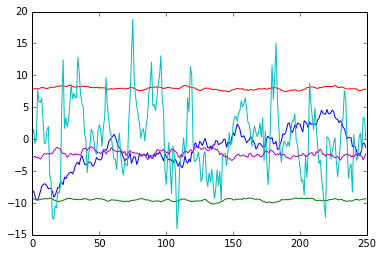

In [13]:
mp.plot(X[:,0:5])

In [14]:
Kx = kernel.K(X[0:N-1])
print(Kx)

[[ 15151.90584171  15097.24523409  15060.7036743  ...,  14851.01195015
   14885.45716332  14858.39446559]
 [ 15097.24523409  15351.65446993  15259.30388377 ...,  14957.73300246
   15004.03920822  14973.41398691]
 [ 15060.7036743   15259.30388377  15453.83751958 ...,  14998.05818474
   15040.23418522  15018.01921164]
 ..., 
 [ 14851.01195015  14957.73300246  14998.05818474 ...,  15183.37641577
   15006.36205668  14911.6501048 ]
 [ 14885.45716332  15004.03920822  15040.23418522 ...,  15006.36205668
   15241.10149106  15017.00973015]
 [ 14858.39446559  14973.41398691  15018.01921164 ...,  14911.6501048
   15017.00973015  15194.82151443]]


In [15]:
def predict_new_frame(N,X,kern,Kx_inv,X_old):
    
    k_x = kern.K(X[0:N-1],X_old)
    #k_xx = kern.K(X_old,X_old)

    meann = np.matmul(np.matmul(np.transpose(X[1:N]),Kx_inv),k_x).flatten()
    #cov = (k_xx - np.matmul(np.matmul(np.transpose(k_x),Kx_inv),k_x)) * np.eye(Q)
    
    #R = np.random.multivariate_normal(meann,cov)
    R = meann
    
    return R

In [16]:
N_synt = 500
X_synt = np.zeros((N_synt,Q))
X_last = X[N-1:N]
Kx_inv = np.linalg.inv(Kx)

for i in range(N_synt):
    X_synt[i,:] = predict_new_frame(N,X,kernel,Kx_inv,X_last.reshape(1,Q))
    X_last = X_synt[i,:]
    
print(X_synt)

[[-1.8790376  -9.3767646   7.89897815 ..., -4.34934175  0.95944106
  -0.78460703]
 [-2.16618481 -9.39275214  7.95048575 ..., -0.40388687  0.84911685
  -0.87610939]
 [-2.50007592 -9.43283101  7.99029786 ...,  0.33255958  0.62676347
  -0.72186741]
 ..., 
 [ 1.60242755 -9.41907976  7.85452789 ..., -6.00047791  1.4066161
   3.52870537]
 [ 0.49337892 -9.44119654  7.88924471 ..., -3.87596233  2.06622441
  -0.04679766]
 [ 0.40497053 -9.45612544  7.93505365 ..., -7.83209015  2.00600638
  -2.21102169]]


In [17]:
X_synt[:,0]

array([-1.8790376 , -2.16618481, -2.50007592, -2.90119539, -3.20070779,
       -3.3414259 , -3.41286288, -3.60482235, -3.83395359, -3.85026841,
       -3.8846017 , -3.85902108, -3.74084543, -3.76738543, -3.6762843 ,
       -3.50964608, -3.12741927, -2.53522074, -2.473903  , -1.50878941,
       -0.87373422, -0.85690732, -1.29752089, -1.11478687, -0.31915626,
       -0.47890012, -0.80953056, -0.3430844 , -0.19951321, -0.98153687,
       -1.25404692, -1.14562383, -1.24142312, -0.92227585, -0.66505433,
       -0.34520143, -0.39512129, -0.83435459, -0.77402333, -0.69649404,
       -0.47761914, -0.05429834, -0.05472128, -1.02415768, -0.54826682,
       -0.52895573, -0.73133133,  0.17682187,  0.90041934,  0.65977851,
        1.58989598,  2.38648891,  2.12101546,  1.60382635,  0.49432493,
        0.40523347,  0.50455131,  0.08282639, -0.52088507, -0.31368085,
       -0.08379667,  0.3652332 ,  0.0697805 , -0.25432592, -0.66237223,
       -1.5168304 , -1.28844512, -0.76551642, -0.71453027, -0.89

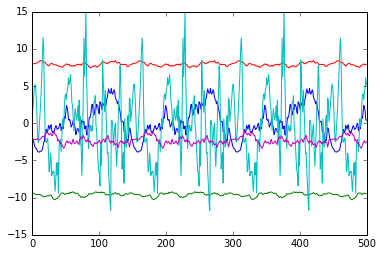

In [24]:
mp.plot(X_synt[:,0:5])

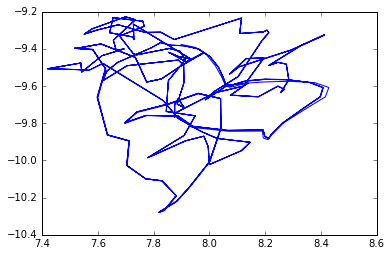

In [19]:
mp.plot(X_synt[:,2],X_synt[:,1])

In [ ]:
def reconstruct_new_frame(N,D,X,Y,kern,Ky_inv,X_synt_i):
    
    R = np.zeros(D)
    
    k_y = kern.K(X,X_synt_i)
    k_yy = kern.K(X_synt_i,X_synt_i)

    meann = np.matmul(np.matmul(np.transpose(Y),Ky_inv),k_y).flatten()
    cov = (k_yy - np.matmul(np.matmul(np.transpose(k_y),Ky_inv),k_y)) * np.eye(D)
    
    R = np.random.multivariate_normal(meann,cov)
    print(R)
    
    return R

In [ ]:
Y_synt = np.zeros((N_synt,D))

kernel2 = GPy.kern.RBF(Q,ARD=True)
Ky = kernel2.K(X)
Ky_inv = np.linalg.inv(Ky)

for i in range(N_synt):
    print(i)
    Y_synt[i,:] = reconstruct_new_frame(N,D,X,sample,kernel2,Ky_inv,X_synt[i,:].reshape(1,Q))
    
print(Y_synt)
print(np.size(Y_synt))

In [ ]:
np.random.multivariate_normal(meann,cov)

In [ ]:
R = np.random.multivariate_normal(meann,cov)
print(R)

In [ ]:
R

In [ ]:
Y = sample_std * R + sample_mean

In [ ]:
Y

In [ ]:
show_frame(R)

In [ ]:
show_frame(Y)

In [ ]:
Y_synt_demorm = sample_std * Y_synt + sample_mean

In [ ]:
Y_synt_demorm[0,:].reshape((w,h)).astype(int)

In [ ]:
Y_synt = np.zeros((N_synt,D))

for i in range(D):
    Y_synt[:,i] = np.sqrt(cov[i,i])*np.random.randn(N_synt) + meann[i]

print(Y_synt)

In [ ]:
# new version:

Y_synt = np.zeros((N_synt,D))

kernel2 = GPy.kern.RBF(Q,ARD=True)
Ky = kernel2.K(X)
Ky_inv = np.linalg.inv(Ky)
Y_t = np.transpose(sample)

for i in range(N_synt):
    
    X_synt_i = X_synt[i,:].reshape(1,Q)
    
    k_y = kernel2.K(X,X_synt_i)
    k_yy = kernel2.K(X_synt_i,X_synt_i)

    meann = np.matmul(np.matmul(Y_t,Ky_inv),k_y)
    cov = (k_yy - np.matmul(np.matmul(np.transpose(k_y),Ky_inv),k_y))
    
    Y_synt[i,:] = np.sqrt(cov)*np.random.randn(D) + meann[i]

print(Y_synt)

In [25]:
# new new version:

Y_synt = np.zeros((N_synt,D))

kernel2 = GPy.kern.RBF(Q,ARD=True)
Ky = kernel2.K(X)
Ky_inv = np.linalg.inv(Ky)
Y_t = np.transpose(sample)


    
k_y = kernel2.K(X,X_synt)
k_yy = kernel2.K(X_synt,X_synt)
meann = np.matmul(np.matmul(Y_t,Ky_inv),k_y)
cov = (k_yy - np.matmul(np.matmul(np.transpose(k_y),Ky_inv),k_y))


for i in range(D):
    Y_synt[:,i] = np.matmul(cov,np.random.randn(N_synt)) + meann[i,:]

print(Y_synt)

[[   0.46274602    0.26060366   -1.06443888 ...,    2.43856232
    -0.31070379    0.15538929]
 [   1.81121788   -0.16129617   -1.19433085 ...,   -1.54430581
    -0.68403664   -2.77445728]
 [   0.68225845    3.33407359    0.86799092 ...,   -1.41265778
     1.12862087    2.42103426]
 ..., 
 [ 113.51438246   88.11427975   85.5047129  ...,   56.68282388
    58.88401296   52.38907492]
 [ 117.0244159   114.32445956   92.65448729 ...,  112.8606168    71.09305401
    95.15054662]
 [ 106.78715247  132.53017005  104.04218197 ...,  136.15814753
   110.79363742  126.53682964]]


In [ ]:
kernel2 = GPy.kern.RBF(Q,ARD=True)
Ky = kernel2.K(X)
Ky_inv = np.linalg.inv(Ky)
Y_t = np.transpose(sample)

k_y = kernel2.K(X,X_synt)
k_yy = kernel2.K(X_synt,X_synt) + np.eye(N_synt)*1
meann = np.matmul(np.matmul(Y_t,Ky_inv),k_y)
cov = (k_yy - np.matmul(np.matmul(np.transpose(k_y),Ky_inv),k_y))

In [ ]:
cov

In [ ]:
np.sqrt(cov)

In [ ]:
Y_synt_demorm = sample_std * Y_synt + sample_mean

In [ ]:

sample_mean = np.mean(Y_synt, 0)
sample_std = np.std(Y_synt, 0)

Y_synt_demorm = sample_std * Y_synt + sample_mean


In [ ]:
print(Y_synt[0,:])

In [ ]:
sample_mean

In [ ]:
np.size(Y_synt)

In [ ]:
120*90*500

In [ ]:
img = Y_synt[5,:].reshape((h,w))

In [ ]:
frame222 = mp.imshow(),cmap='Greys_r')

In [ ]:
mp.imsave('data/test.png',Y_synt[5,:].reshape((h,w)),cmap='Greys_r')

In [26]:
Y_synt[:,:].min()

-9.2299570463889093

In [27]:
Y_synt[:,:].max()

206.10312867892404

In [ ]:
sample_mean

In [ ]:
Y_synt[:,:].min()

In [ ]:
Y_synt[:,:].max()

In [ ]:
Y_synt2 = Y_synt - Y_synt[:,:].min()

In [ ]:
Y_synt2[:,:].min()

In [ ]:
Y_synt2 = Y_synt2 * (255/Y_synt2[:,:].max())

In [ ]:
Y_synt2[:,:].max()

In [28]:
Y_synt_demorm = Y_synt

In [ ]:
# last version for saving the video

cap = cv2.VideoCapture(0)
#fourcc = cv2.VideoWriter_fourcc(*'DIB ')
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('data\output.avi',fourcc, 25.0, (w,h))

for i in range(N_synt):
    print(i)
    frame = Y_synt_demorm[i,:].reshape((h,w)).astype(int)
    img = np.zeros((90,120,3), np.uint8)
    img[:,:,0] = frame/3
    img[:,:,1] = frame/3
    img[:,:,2] = frame/3
    #colorFrame = np.zeros((w,h,3), np.uint8)
    #colorFrame = cv2.COLOR_GRAY2RGB(frame)
    #new_frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    #colorFrame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    out.write(img)
    print(img)

cap.release()
out.release()
cv2.destroyAllWindows()
print('Done!')

In [29]:
# The latest version for saving the video

#cap = cv2.VideoCapture(0)
#fourcc = cv2.VideoWriter_fourcc(*'DIB ')
#fourcc = cv2.VideoWriter_fourcc(*'XVID')
#out = cv2.VideoWriter('data\output.avi',fourcc, 25.0, (w,h))

for i in range(N_synt):
    print(i)
    frame = Y_synt_demorm[i,:].reshape((h,w)).astype(int)
    
    ind = 'data/test' + str(i) + '.jpg'
    mp.imsave(ind,frame,cmap='Greys_r')
    #img = mp.imread('data/test.png')
    
    #out.write(img)
    #print(img)

#cap.release()
#out.release()
cv2.destroyAllWindows()
print('Done!')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27